In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [2]:
ticker         = params.ticker
features_cols  = params.features_cols
label_col      = params.label_col
look_back      = params.look_back 

save_path = Path(params.save_path)
in_path   = save_path / f"{ticker}_ready.csv"
out_path  = save_path / f"{ticker}_final.csv"

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

Using device: cuda


In [3]:
# create the _final.csv from the _ready.csv (if the _ready has been modified today or if the _final hasn´t been created yet)

def was_modified_today(path: Path) -> bool:
    """
    Return True if path exists AND its modification date is exactly today.
    """
    if not path.exists():
        return False

    # get the file's last‐modified timestamp, convert to a date
    mtime     = path.stat().st_mtime
    file_date = dt.datetime.fromtimestamp(mtime).date()

    # compare to today's date
    return file_date == dt.date.today()


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build your features and return a cleaned DataFrame.
    """
    # 1) intraday log‐returns
    for lag in (1, 5, 15):
        df[f"r_{lag}"] = np.log(df["close"] / df["close"].shift(lag))

    # 2) volatility & volume spikes
    df["vol_15"]       = df["r_1"].rolling(15).std()
    df["volume_spike"] = df["volume"] / df["volume"].rolling(15).mean()

    # 3) VWAP deviation
    typ_price     = (df["high"] + df["low"] + df["close"]) / 3
    vwap          = (typ_price * df["volume"]).cumsum() \
                    / df["volume"].cumsum()
    df["vwap_dev"] = (df["close"] - vwap) / vwap

    # 4) 14‐period RSI
    delta     = df["close"].diff()
    gain      = delta.clip(lower=0)
    loss      = -delta.clip(upper=0)
    avg_gain  = gain.rolling(14).mean()
    avg_loss  = loss.rolling(14).mean()
    rs        = avg_gain / avg_loss
    df["rsi_14"] = 100 - (100 / (1 + rs))

    # 5) filter down to your features + bid/ask + label
    df = df[features_cols + ["bid", "ask", label_col]].dropna()
    return df


# ─── Decide whether to rebuild or just load ────────────────────────────────
# Rebuild if:
#   - final CSV isn't there, OR
#   - the "ready" CSV was modified today
if (not out_path.exists()) or was_modified_today(in_path):
    print(f"→ Running feature_engineering on {in_path.name}")
    raw = pd.read_csv(in_path, index_col=0, parse_dates=True)
    df  = feature_engineering(raw)
    print(f"→ Saving enriched data to {out_path.name}")
    df.to_csv(out_path)
else:
    print(f"→ {out_path.name} is up‐to‐date; loading")
    df = pd.read_csv(out_path, index_col=0, parse_dates=True)

df  # now ready for downstream use


→ Running feature_engineering on GOOGL_ready.csv
→ Saving enriched data to GOOGL_final.csv


,open,high,low,close,volume,r_1,r_5,r_15,vol_15,volume_spike,vwap_dev,rsi_14,bid,ask,signal_smooth
2014-04-03 12:06:00,28.644845,28.644845,28.644845,28.644845,4580.0,-0.000180,-0.000180,-0.000180,0.000046,0.568641,-0.000177,0.000000,28.636251,28.653438,0.162925
2014-04-03 12:07:00,28.639690,28.639690,28.639690,28.639690,4540.0,-0.000180,-0.000360,-0.000360,0.000063,0.570338,-0.000352,0.000000,28.631098,28.648282,0.164530
2014-04-03 12:08:00,28.634534,28.634534,28.634534,28.634534,4500.0,-0.000180,-0.000540,-0.000540,0.000075,0.574408,-0.000524,0.000000,28.625944,28.643125,0.166141
2014-04-03 12:09:00,28.629379,28.629379,28.629379,28.629379,4460.0,-0.000180,-0.000720,-0.000720,0.000082,0.581017,-0.000694,0.000000,28.620791,28.637968,0.167757
2014-04-03 12:10:00,28.624224,28.624224,28.624224,28.624224,4420.0,-0.000180,-0.000900,-0.000900,0.000088,0.590413,-0.000862,0.000000,28.615637,28.632811,0.169381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17 20:56:00,176.090000,176.160000,176.010000,176.050000,126589.0,-0.000284,-0.000681,-0.001297,0.000443,1.610125,1.217786,39.325843,175.997200,176.102800,0.000000
2025-06-17 20:57:00,176.050000,176.080000,175.890000,175.930000,125176.0,-0.000682,-0.000398,-0.001761,0.000469,1.478464,1.216271,34.328358,175.877200,175.982800,0.000000
2025-06-17 20:58:00,175.930000,175.975000,175.860000,175.890000,200235.0,-0.000227,-0.001023,-0.002016,0.000468,2.096227,1.215761,29.648241,175.837200,175.942800,0.000000
2025-06-17 20:59:00,175.900000,175.970000,175.800000,175.930000,393414.0,0.000227,-0.001136,-0.002073,0.000464,3.295458,1.216254,25.925926,175.877200,175.982800,0.000000


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
# Build LSTM input tensors (disk-backed memmaps)
#    Returns five tensors on `device`:
#      X        : (N, look_back, F)
#      y        : (N,)
#      raw_close: (N,)
#      raw_bid  : (N,)
#      raw_ask  : (N,)
# ──────────────────────────────────────────────────────────────────────────────
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df             = df,
    look_back      = look_back,
    features_cols  = features_cols,
    label_col      = label_col,
    regular_start  = params.regular_start_pred
)

print("Shapes:")
print("  X         =", X.shape,    "(samples, features, look_back)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

Shapes:
  X         = torch.Size([1174595, 120, 12]) (samples, features, look_back)
  y         = torch.Size([1174595]) (samples,)
  raw_close = torch.Size([1174595])
  raw_bid   = torch.Size([1174595])
  raw_ask   = torch.Size([1174595])


In [5]:
# ──────────────────────────────────────────────────────────────────────────────
#    (We use the helper `chronological_split` that returns)
#      (X_tr, y_tr),
#      (X_val, y_val),
#      (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te)
# ──────────────────────────────────────────────────────────────────────────────
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back       = look_back,
    regular_start   = params.regular_start_pred,
    train_prop      = params.train_prop,
    val_prop        = params.val_prop,
    train_batch     = params.hparams['TRAIN_BATCH']
)

print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([800997, 120, 12])
  y_tr        = torch.Size([800997])
  raw_close_te= torch.Size([190594])
  raw_bid_te  = torch.Size([190594])
  raw_ask_te  = torch.Size([190594])


In [6]:
# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"\nBaseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=800997, val=183004, te=190594
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..358], total days=359
   te_day_id  ∈ [0..372], total days=373
4) instantiating DayWindowDatasets
   ds_tr days: 1760
   ds_val days: 359
   ds_te days: 373
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready

Baseline (zero‐forecast) RMSE on validation = 0.378654


In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────
def objective_train(trial):
    # Sample only the knobs you care about
    hp = {
        # Architecture
        "DROPOUT_SHORT"        : trial.suggest_float("DROPOUT_SHORT",     0.1, 0.5),
        "DROPOUT_LONG"         : trial.suggest_float("DROPOUT_LONG",      0.1, 0.5),
        "ATT_HEADS"            : trial.suggest_categorical("ATT_HEADS",  [2, 4, 8]),
        "ATT_DROPOUT"          : trial.suggest_float("ATT_DROPOUT",       0.1, 0.5),

        # Optimizer & scheduler
        "INITIAL_LR"           : trial.suggest_float("INITIAL_LR",       1e-4, 1e-2),
        "ETA_MIN"              : trial.suggest_float("ETA_MIN",          1e-6, 1e-3),
        "WEIGHT_DECAY"         : trial.suggest_float("WEIGHT_DECAY",     1e-6, 1e-2),
        "CLIPNORM"             : trial.suggest_float("CLIPNORM",         0.0, 1.0),
        "LR_EPOCHS_WARMUP"     : trial.suggest_int  ("LR_EPOCHS_WARMUP", 0, 12),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    # Build model
    model = models.DualMemoryLSTM(
        n_feats       = len(features_cols),
        short_units   = params.hparams["SHORT_UNITS"],
        long_units    = params.hparams["LONG_UNITS"],
        dropout_short = hp["DROPOUT_SHORT"],
        dropout_long  = hp["DROPOUT_LONG"],
        att_heads     = hp["ATT_HEADS"],
        att_drop      = hp["ATT_DROPOUT"],
    ).to(device)

    # Build optimizer + schedulers + scaler
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )

    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )

    # Run training & return best validation RMSE
    best_rmse = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams["MAX_EPOCHS"],
        early_stop_patience = params.hparams["EARLY_STOP_PATIENCE"],
        baseline_val_rmse   = baseline_val_rmse,
        clipnorm            = clipnorm,
        device              = device,
    )
    return best_rmse



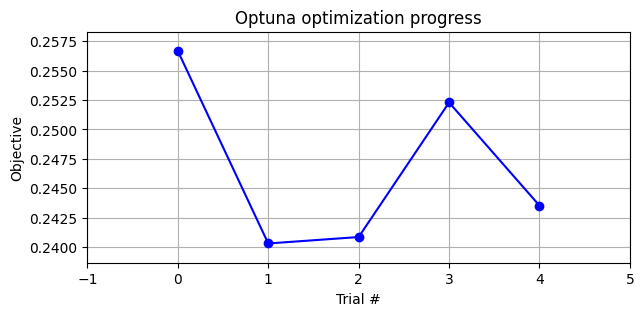

In [8]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-07-22 16:59:05,726] A new study created in memory with name: no-name-43872059-ddb4-444b-9e75-8e89d56f85d7



▶ Trial 0 starting with:
{'DROPOUT_SHORT': 0.30599372269260977, 'DROPOUT_LONG': 0.20829525563428708, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.4036265035838157, 'INITIAL_LR': 0.0035164348164117734, 'ETA_MIN': 0.0009973296741573369, 'WEIGHT_DECAY': 0.009418287866225665, 'CLIPNORM': 0.4596280170803253, 'LR_EPOCHS_WARMUP': 6}



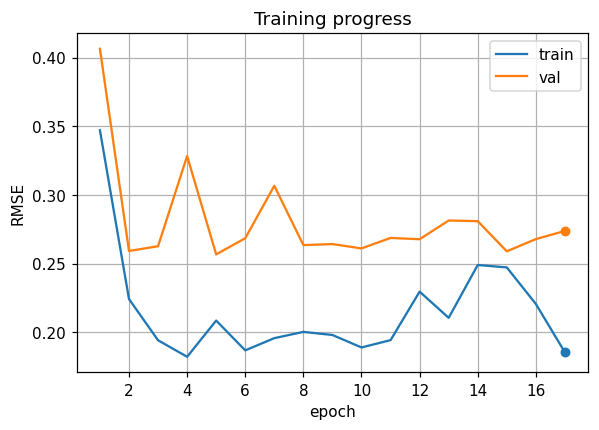

Epoch 1:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3471 • val=0.4065 • lr=3.51e-03


Epoch 2:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2241 • val=0.2592 • lr=3.51e-03


Epoch 3:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1941 • val=0.2626 • lr=3.50e-03


Epoch 4:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1821 • val=0.3284 • lr=3.49e-03


Epoch 5:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2085 • val=0.2567 • lr=3.47e-03


Epoch 6:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1867 • val=0.2685 • lr=3.46e-03


Epoch 7:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1956 • val=0.3066 • lr=3.43e-03


Epoch 8:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2002 • val=0.2634 • lr=3.41e-03


Epoch 9:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1980 • val=0.2642 • lr=3.38e-03


Epoch 10:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1889 • val=0.2610 • lr=3.35e-03


Epoch 11:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1942 • val=0.2687 • lr=3.31e-03


Epoch 12:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2295 • val=0.2677 • lr=3.28e-03


Epoch 13:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2105 • val=0.2814 • lr=3.24e-03


Epoch 14:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2490 • val=0.2809 • lr=3.19e-03


Epoch 15:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2472 • val=0.2589 • lr=3.15e-03


Epoch 16:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2205 • val=0.2678 • lr=3.10e-03


Epoch 17:   0%|          | 0/55 [00:00<?, ?bundle/s]

[I 2025-07-22 17:05:28,122] Trial 0 finished with value: 0.2566744741644738 and parameters: {'DROPOUT_SHORT': 0.30599372269260977, 'DROPOUT_LONG': 0.20829525563428708, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.4036265035838157, 'INITIAL_LR': 0.0035164348164117734, 'ETA_MIN': 0.0009973296741573369, 'WEIGHT_DECAY': 0.009418287866225665, 'CLIPNORM': 0.4596280170803253, 'LR_EPOCHS_WARMUP': 6}. Best is trial 0 with value: 0.2566744741644738.


Epoch 017 • train=0.1853 • val=0.2737 • lr=3.05e-03
Early stopping at epoch 17
Saved full model + hparams to dfs training/GOOGL_0.2567.pth

▶ Trial 1 starting with:
{'DROPOUT_SHORT': 0.16701561042071966, 'DROPOUT_LONG': 0.3267730186872636, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.4642075041269115, 'INITIAL_LR': 0.003063640676287226, 'ETA_MIN': 0.00018201910185896005, 'WEIGHT_DECAY': 0.0016028014646322292, 'CLIPNORM': 0.08644484686907172, 'LR_EPOCHS_WARMUP': 9}



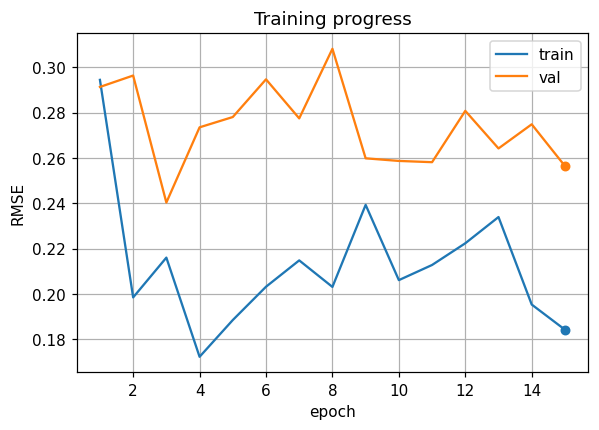

Epoch 1:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2945 • val=0.2913 • lr=3.06e-03


Epoch 2:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1985 • val=0.2964 • lr=3.06e-03


Epoch 3:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2160 • val=0.2403 • lr=3.05e-03


Epoch 4:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1722 • val=0.2735 • lr=3.03e-03


Epoch 5:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1885 • val=0.2781 • lr=3.01e-03


Epoch 6:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2032 • val=0.2947 • lr=2.99e-03


Epoch 7:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2148 • val=0.2775 • lr=2.97e-03


Epoch 8:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2031 • val=0.3082 • lr=2.94e-03


Epoch 9:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2393 • val=0.2598 • lr=2.91e-03


Epoch 10:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2061 • val=0.2587 • lr=2.87e-03


Epoch 11:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2128 • val=0.2581 • lr=2.83e-03


Epoch 12:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2223 • val=0.2808 • lr=2.79e-03


Epoch 13:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2339 • val=0.2642 • lr=2.74e-03


Epoch 14:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1953 • val=0.2748 • lr=2.69e-03


Epoch 15:   0%|          | 0/55 [00:00<?, ?bundle/s]

[I 2025-07-22 17:11:46,322] Trial 1 finished with value: 0.24030596188900213 and parameters: {'DROPOUT_SHORT': 0.16701561042071966, 'DROPOUT_LONG': 0.3267730186872636, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.4642075041269115, 'INITIAL_LR': 0.003063640676287226, 'ETA_MIN': 0.00018201910185896005, 'WEIGHT_DECAY': 0.0016028014646322292, 'CLIPNORM': 0.08644484686907172, 'LR_EPOCHS_WARMUP': 9}. Best is trial 1 with value: 0.24030596188900213.


Epoch 015 • train=0.1842 • val=0.2564 • lr=2.64e-03
Early stopping at epoch 15
Saved full model + hparams to dfs training/GOOGL_0.2403.pth

▶ Trial 2 starting with:
{'DROPOUT_SHORT': 0.24869404155099592, 'DROPOUT_LONG': 0.1939275334982345, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.20234430364713898, 'INITIAL_LR': 0.007320999826952079, 'ETA_MIN': 4.8727759583036866e-05, 'WEIGHT_DECAY': 0.00040236456431827706, 'CLIPNORM': 0.9510842985382627, 'LR_EPOCHS_WARMUP': 10}



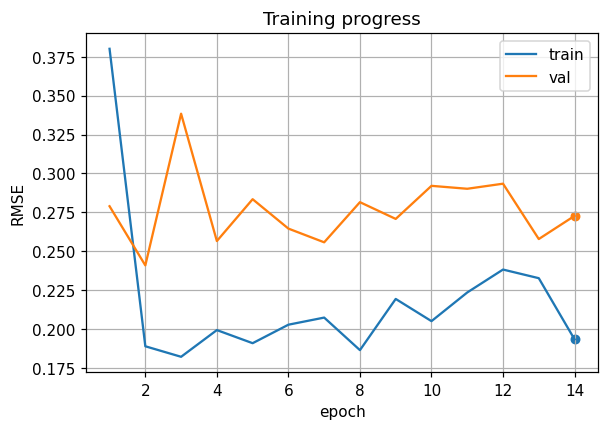

Epoch 1:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3801 • val=0.2789 • lr=7.32e-03


Epoch 2:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1888 • val=0.2409 • lr=7.30e-03


Epoch 3:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1821 • val=0.3384 • lr=7.28e-03


Epoch 4:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1993 • val=0.2565 • lr=7.24e-03


Epoch 5:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1908 • val=0.2834 • lr=7.20e-03


Epoch 6:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2027 • val=0.2645 • lr=7.14e-03


Epoch 7:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2073 • val=0.2557 • lr=7.08e-03


Epoch 8:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1864 • val=0.2815 • lr=7.01e-03


Epoch 9:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2193 • val=0.2707 • lr=6.93e-03


Epoch 10:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2050 • val=0.2920 • lr=6.84e-03


Epoch 11:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2234 • val=0.2901 • lr=6.74e-03


Epoch 12:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2382 • val=0.2934 • lr=6.63e-03


Epoch 13:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2326 • val=0.2578 • lr=6.51e-03


Epoch 14:   0%|          | 0/55 [00:00<?, ?bundle/s]

[I 2025-07-22 17:17:02,021] Trial 2 finished with value: 0.24085303885200135 and parameters: {'DROPOUT_SHORT': 0.24869404155099592, 'DROPOUT_LONG': 0.1939275334982345, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.20234430364713898, 'INITIAL_LR': 0.007320999826952079, 'ETA_MIN': 4.8727759583036866e-05, 'WEIGHT_DECAY': 0.00040236456431827706, 'CLIPNORM': 0.9510842985382627, 'LR_EPOCHS_WARMUP': 10}. Best is trial 1 with value: 0.24030596188900213.


Epoch 014 • train=0.1933 • val=0.2727 • lr=6.39e-03
Early stopping at epoch 14
Saved full model + hparams to dfs training/GOOGL_0.2409.pth

▶ Trial 3 starting with:
{'DROPOUT_SHORT': 0.27990047893026754, 'DROPOUT_LONG': 0.3877852621379393, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.2477616496657638, 'INITIAL_LR': 0.00921690669812697, 'ETA_MIN': 0.0003520614754014031, 'WEIGHT_DECAY': 0.0023064536577554313, 'CLIPNORM': 0.25456308970619446, 'LR_EPOCHS_WARMUP': 5}



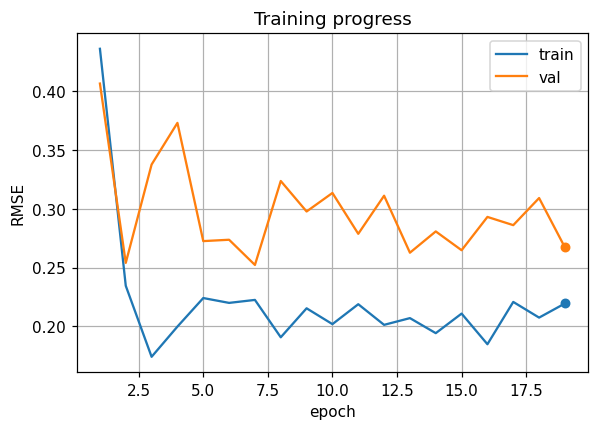

Epoch 1:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4360 • val=0.4064 • lr=9.21e-03


Epoch 2:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2346 • val=0.2541 • lr=9.19e-03


Epoch 3:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1742 • val=0.3376 • lr=9.16e-03


Epoch 4:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1999 • val=0.3730 • lr=9.12e-03


Epoch 5:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2242 • val=0.2726 • lr=9.07e-03


Epoch 6:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2201 • val=0.2737 • lr=9.00e-03


Epoch 7:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2226 • val=0.2523 • lr=8.92e-03


Epoch 8:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1908 • val=0.3236 • lr=8.84e-03


Epoch 9:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2155 • val=0.2977 • lr=8.74e-03


Epoch 10:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2020 • val=0.3135 • lr=8.63e-03


Epoch 11:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2189 • val=0.2788 • lr=8.50e-03


Epoch 12:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2014 • val=0.3111 • lr=8.37e-03


Epoch 13:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2071 • val=0.2627 • lr=8.23e-03


Epoch 14:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1943 • val=0.2808 • lr=8.08e-03


Epoch 15:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2110 • val=0.2648 • lr=7.92e-03


Epoch 16:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1849 • val=0.2931 • lr=7.75e-03


Epoch 17:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2209 • val=0.2861 • lr=7.58e-03


Epoch 18:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2076 • val=0.3091 • lr=7.39e-03


Epoch 19:   0%|          | 0/55 [00:00<?, ?bundle/s]

[I 2025-07-22 17:24:11,064] Trial 3 finished with value: 0.2522931787931867 and parameters: {'DROPOUT_SHORT': 0.27990047893026754, 'DROPOUT_LONG': 0.3877852621379393, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.2477616496657638, 'INITIAL_LR': 0.00921690669812697, 'ETA_MIN': 0.0003520614754014031, 'WEIGHT_DECAY': 0.0023064536577554313, 'CLIPNORM': 0.25456308970619446, 'LR_EPOCHS_WARMUP': 5}. Best is trial 1 with value: 0.24030596188900213.


Epoch 019 • train=0.2196 • val=0.2672 • lr=7.20e-03
Early stopping at epoch 19
Saved full model + hparams to dfs training/GOOGL_0.2523.pth

▶ Trial 4 starting with:
{'DROPOUT_SHORT': 0.23071942275805726, 'DROPOUT_LONG': 0.39541958034481206, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.1944277661322775, 'INITIAL_LR': 0.003679819195646182, 'ETA_MIN': 0.00041481468215198627, 'WEIGHT_DECAY': 0.00816566421353576, 'CLIPNORM': 0.49385646969046804, 'LR_EPOCHS_WARMUP': 7}



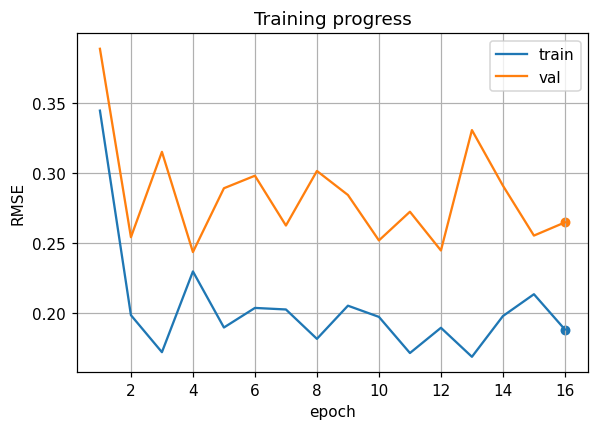

Epoch 1:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3446 • val=0.3888 • lr=3.68e-03


Epoch 2:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1984 • val=0.2541 • lr=3.67e-03


Epoch 3:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1720 • val=0.3151 • lr=3.66e-03


Epoch 4:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2297 • val=0.2435 • lr=3.64e-03


Epoch 5:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1896 • val=0.2891 • lr=3.62e-03


Epoch 6:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2036 • val=0.2981 • lr=3.60e-03


Epoch 7:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2025 • val=0.2625 • lr=3.57e-03


Epoch 8:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1815 • val=0.3015 • lr=3.54e-03


Epoch 9:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2052 • val=0.2843 • lr=3.50e-03


Epoch 10:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1972 • val=0.2518 • lr=3.46e-03


Epoch 11:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1714 • val=0.2723 • lr=3.42e-03


Epoch 12:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1894 • val=0.2447 • lr=3.37e-03


Epoch 13:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1687 • val=0.3307 • lr=3.32e-03


Epoch 14:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1978 • val=0.2910 • lr=3.26e-03


Epoch 15:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2134 • val=0.2553 • lr=3.20e-03


Epoch 16:   0%|          | 0/55 [00:00<?, ?bundle/s]

[I 2025-07-22 17:33:10,649] Trial 4 finished with value: 0.2435260251878601 and parameters: {'DROPOUT_SHORT': 0.23071942275805726, 'DROPOUT_LONG': 0.39541958034481206, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.1944277661322775, 'INITIAL_LR': 0.003679819195646182, 'ETA_MIN': 0.00041481468215198627, 'WEIGHT_DECAY': 0.00816566421353576, 'CLIPNORM': 0.49385646969046804, 'LR_EPOCHS_WARMUP': 7}. Best is trial 1 with value: 0.24030596188900213.


Epoch 016 • train=0.1882 • val=0.2647 • lr=3.14e-03
Early stopping at epoch 16
Saved full model + hparams to dfs training/GOOGL_0.2435.pth

▶ Trial 5 starting with:
{'DROPOUT_SHORT': 0.2752240058793497, 'DROPOUT_LONG': 0.38848790237588926, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3143312064339846, 'INITIAL_LR': 0.008505864578960411, 'ETA_MIN': 0.0004899043565346714, 'WEIGHT_DECAY': 0.0084822268310861, 'CLIPNORM': 0.28193792388654604, 'LR_EPOCHS_WARMUP': 8}



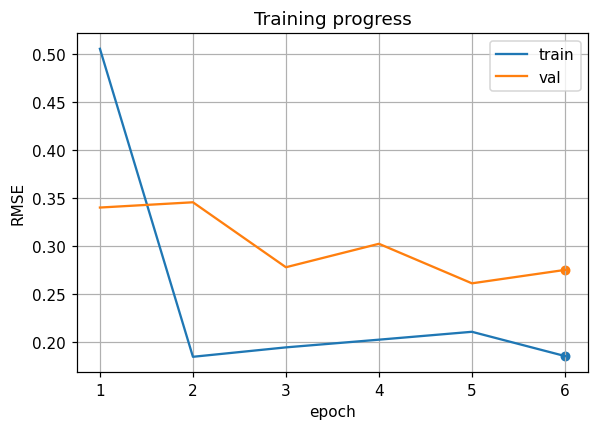

Epoch 1:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 001 • train=0.5058 • val=0.3404 • lr=8.50e-03


Epoch 2:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1849 • val=0.3459 • lr=8.48e-03


Epoch 3:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1947 • val=0.2782 • lr=8.46e-03


Epoch 4:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2027 • val=0.3026 • lr=8.42e-03


Epoch 5:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2109 • val=0.2614 • lr=8.37e-03


Epoch 6:   0%|          | 0/55 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1856 • val=0.2754 • lr=8.31e-03


Epoch 7:   0%|          | 0/55 [00:00<?, ?bundle/s]

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────
study = optuna.create_study(
    direction="minimize",
    pruner   = MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)
study.optimize(
    objective_train,
    n_trials = 120,
    n_jobs   = 1,
    callbacks=[live_cb],
)

# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
start_date  = df.index.min().strftime("%Y%m%d")
end_date    = df.index.max().strftime("%Y%m%d")
file_name   = f"{ticker}_{start_date}-{end_date}_optuna_hyperpars.json"
file_path   = os.path.join(results_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
